# Patent Scraper

In [1]:
import requests
from bs4 import BeautifulSoup
import pypatent

def clean_text(text):
    text = text.replace('\n', '')
    text = text.replace('\xa0', '')
    
    return text

### Algae Example

In [ ]:
import pandas as pd
import csv

f = open('data/italic_storage.csv', "w", newline='')
writer = csv.writer(f)
csv_df = pd.read_csv("data/algae.csv", skiprows = [0])
first_row = ['Patent title', 'Patent link', 'italic list']
writer.writerow(first_row)
csv_df = csv_df.head(n = 1000)

patents_dictionary = {}

for idx, row in csv_df.iterrows():
    csv_line = []
    link = row['result link']
    patent_d = {}
    print("Patent number: ", idx, " - ", link,  '\n')
    
    patent_d['url'] = link
    
    soup = BeautifulSoup(requests.get(link).content, 'html.parser')

    for s in soup.find_all('span', attrs={'class':'google-src-text'}):
        s.extract() 
        
    try:
        title = soup.title.text
        title = title.replace("\n",'')
        title = title.split(' - ')[1]
        title = " ".join(title.split())
        patent_d['title'] = title
        csv_line.append(title)
        csv_line.append(link)
        print("   ", title, "\n")
    except:
        patent_d['title'] = ''
    
    try:
        abstract = soup.abstract.text
        patent_d['abstract'] = clean_text(abstract)   
    except:
        patent_d['abstract'] = ''        

    try:
        italic = []
        for it in soup.find_all('i'):
            italic.append(it.text)
        csv_line.append(italic)
        patent_d['italic'] = len(italic) 
    except:
        patent_d['italic'] = 0
    
    try:
        text_list = []
        for desc in soup.find_all('div', attrs={'class': 'description'}):
            text_ = clean_text(desc.text)
            text_ = str(text_).split(".")

            for elem in text_:
                if 'algae' in elem: 
                    text_list.append(elem)
                    
        for claim in soup.find_all('div', attrs={'class': 'claim'}):
            text_ = clean_text(claim.text)
            text_ = str(text_).split(".")

            for item in text_:
                if 'algae' in item: 
                    text_list.append(item)
                
        patent_d['text'] = text_list
    except:
        patent_d['text'] = ''
        
    patents_dictionary[idx] = patent_d
    try:
        writer.writerow(csv_line)
    except:
        csv_line = [title.encode("UTF-8"), link, 'Encoding error']
        writer.writerow(csv_line)
    print(csv_line)

f.close()
# print(patents_dictionary)

Patent number:  0  -  https://patents.google.com/patent/JP5127983B2/en 

    A kind of low current electrolysis sterilization algae device and method 

['A kind of low current electrolysis sterilization algae device and method', 'https://patents.google.com/patent/JP5127983B2/en', []]
Patent number:  1  -  https://patents.google.com/patent/KR100609736B1/en 

    Device and method for cultivating micro algae 

['Device and method for cultivating micro algae', 'https://patents.google.com/patent/KR100609736B1/en', []]
Patent number:  2  -  https://patents.google.com/patent/RU2610672C2/en 

    Aquatic-based microalgae production apparatus 

['Aquatic-based microalgae production apparatus', 'https://patents.google.com/patent/RU2610672C2/en', []]
Patent number:  3  -  https://patents.google.com/patent/US9708207B2/en 

    Method and apparatus for upflow algae scrubber, macroalgal photobioreactor and sea weed cultivator 

['Method and apparatus for upflow algae scrubber, macroalgal photobiore

In [268]:
ordered = []
for key, val in patents_dictionary.items():
    ordered.append(val)
ordered = sorted(ordered, key=lambda k: k['italic'], reverse = True) 

for elem in ordered[:30]:
    print(elem['title'], " - ", elem['italic'])

Highly conserved genes and their use to generate species-specific, genus-specific, family-specific, group-specific and universal nucleic acid probes and amplification primers to rapidly detect and identify algal, archaeal, bacterial, fungal and parasitical microorgamisms from clinical specimens for diagnosis  -  9426
Recombinant microalgae including keto-acyl ACP synthase  -  1285
Heterotrophic microalgae expressing invertase  -  1096
Microalgae cultivation in a wastewater dominated by carpet mill effluents for biofuel applications  -  777
Methods for producing a triglyceride composition from algae  -  762
Transformation of algae for increasing lipid production  -  516
Method of enhanced sustainable production of algal bio-products, comprising use of symbiotic diazotroph-attenuated stress co-cultivation  -  493
Microalgae-derived compositions for improving the health and appearance of skin  -  405
Nutraceutical Compositions From Microalgae And Related Methods of Production And Administ

### Doc2Vec 

In [279]:
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [280]:
# Generating data input (training set) with the text of the patents
data = []
for key, val in patents_dictionary.items():
    data.append("".join(val['text']))  
    
# for idx, elem in enumerate(data):
#     print(idx, ' - ', elem[0:20] + '..')

tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]
# print(tagged_data)

In [297]:
max_epochs = 500
vec_size = 100 #100 - 200 - 300
alpha = 0.025

model = Doc2Vec(vector_size = vec_size,
                alpha=alpha,
                min_alpha=0.00025,
                min_count=1,
                dm =1)

# window = 10

model.build_vocab(tagged_data)

print("Iterating throug epochs..", end = '')
for epoch in range(max_epochs):
#     print('iteration {0}'.format(epoch))
    print(".", end = '')
    model.train(tagged_data,
    total_examples=model.corpus_count,
    epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
print("Done!")

model.save("Models/last_100500.model")
print("Model Saved")


Iterating throug epochs......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Done!
Model Saved


In [283]:
# print(patents_dictionary.keys())

In [387]:
from gensim.models.doc2vec import Doc2Vec
import pandas as pd

model = Doc2Vec.load("Models/last_200500.model")

#  To be defined
TRASHOLD = 0.85
# to find most similar doc using tags
print("MOST SIMILAR DOCUMENTS.. ",  end='')
edges = []
nodes_tmp = []
dataframe = []

edges_ = []
nodes_tmp_ = []
dataframe_ = []

r = 0
for i in range(500):
    similar_doc = model.docvecs.most_similar(str(i), topn=500)
    entry = { 'source' : i, 'target': i, 'distance': 1}
    dataframe.append(entry)
    for doc in similar_doc:
        
        if doc[1] > TRASHOLD:
            entry = { 'source' : i, 'target': int(doc[0]), 'distance': doc[1]}
            dataframe.append(entry)
            if r < 50:
                print("-"*130,  "\n")
                print([i], "-", [int(doc[0])], "-", doc[1], "\n")
                print([i], patents_dictionary[i]['title'])
                print([int(doc[0])], patents_dictionary[int(doc[0])]['title'], "\n")
            r = r + 1
#         print('Source: ', i, 'Target: ', int(doc[0]), 'distance:', 1- doc[1])
            
            nodes_tmp.append({"data": {"id": i, "label": patents_dictionary[i]['title']},"classes" : 'followerNode'})
            nodes_tmp.append({"data": {"id": int(doc[0]), "label": patents_dictionary[int(doc[0])]['title']},"classes" : 'followingNode'})

            temp = {'data':{
                  'source': i,
                  'target': int(doc[0]),
                  'distance': doc[1]
                  }
            }
            edges.append(temp)
            
print("Done!")
df = pd.DataFrame(dataframe) 

MOST SIMILAR DOCUMENTS.. ---------------------------------------------------------------------------------------------------------------------------------- 

[9] - [14] - 0.9642621874809265 

[9] Algal and nutrient control system and method for a body of water
[14] Algal and nutrient control method for a body of water 

---------------------------------------------------------------------------------------------------------------------------------- 

[14] - [9] - 0.9642622470855713 

[14] Algal and nutrient control method for a body of water
[9] Algal and nutrient control system and method for a body of water 

---------------------------------------------------------------------------------------------------------------------------------- 

[19] - [125] - 0.9029845595359802 

[19] Optimization of algal product production through uncoupling cell proliferation and algal product production
[125] Process for the production of microalgae, cyanobacteria and their metabolites 

-------------

In [388]:
df = pd.DataFrame(dataframe)
display(df)

,source,target,distance
0,0,0,1.0
1,1,1,1.0
2,2,2,1.0
3,3,3,1.0
4,4,4,1.0
...,...,...,...
645,495,495,1.0
646,496,496,1.0
647,497,497,1.0
648,498,498,1.0


In [389]:
pivot_table = df.pivot('source','target','distance').fillna(0)
display(pivot_table)

target,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
source,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [390]:
import pickle
filename = 'historical_codes/data_network.p'
outfile = open(filename,'wb')

# Remove duplicates from nodes_tmp --> nodes
nodes = []
for value in nodes_tmp:
    if value not in nodes:
        nodes.append(value)

data_network = {1: nodes, 2:edges}
pickle.dump(data_network, outfile)
outfile.close()
print(f'Data loaded in pickle file: {filename}')  #'Hello, {}'.format(name)
# print(('Data loaded in pickle file {}'.format(filename)))

Data loaded in pickle file: historical_codes/data_network.p


In [391]:
infile = open("data/data_network.p",'rb')
data_network = pickle.load(infile)
# print(data_network[1])
infile.close()

In [392]:
from sklearn.cluster import SpectralBiclustering
from sklearn.datasets import make_checkerboard

from matplotlib import pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Original dataset')

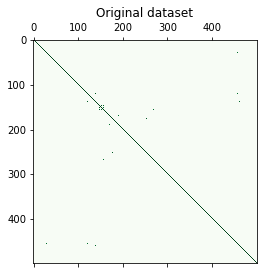

In [393]:
plt.matshow(pivot_table, cmap=plt.cm.Greens)
plt.title("Original dataset")

In [394]:
arr_checkboard = np.array(pivot_table)
display(arr_checkboard)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [395]:
model = SpectralBiclustering(n_clusters=2, method='scale',     # method='log'
                             random_state=0)

In [396]:
model.fit(arr_checkboard)

SpectralBiclustering(method='scale', n_clusters=2, random_state=0)

Text(0.5, 1.0, 'After biclustering; rearranged to show biclusters')

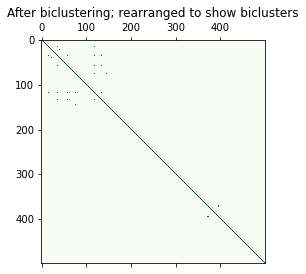

In [397]:
fit_data = arr_checkboard[np.argsort(model.row_labels_)]

# display(fit_data)
fit_data = fit_data[:, np.argsort(model.column_labels_)]

plt.matshow(fit_data, cmap=plt.cm.Greens)
plt.title("After biclustering; rearranged to show biclusters")

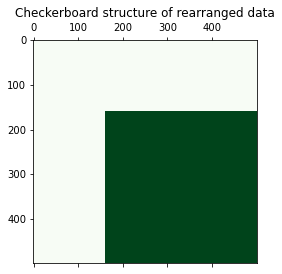

In [398]:
final_checkboard = np.outer(np.sort(model.row_labels_) , np.sort(model.column_labels_))

plt.matshow(final_checkboard,
            cmap=plt.cm.Greens)
plt.title("Checkerboard structure of rearranged data")
plt.show()

In [379]:
display(final_checkboard)
print()
display(fit_data)
l_indices_1 = list(model.get_indices(1)[0])
l_indices_2 = list(model.get_indices(2)[0])
print(len(l_indices_1), " - ", l_indices_1)
print(len(l_indices_2), " - ", l_indices_2)

dict_cluster1 = {}
dict_cluster2 = {}

for key, val in patents_dictionary.items():
    if key in l_indices_1:
        dict_cluster1[key] = val
    else:
        dict_cluster2[key] = val
print()
print("*" * 190)
for k, v in dict_cluster1.items():
    print(v['title'])

        
# display(model.get_indices(3))
# pvot = pd.pivot(fit_data, )

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

array([[1.        , 0.        , 0.        , ..., 0.        , 0.60092103,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.6095469 ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.6715101 ,
        0.70396149],
       [0.60092103, 0.        , 0.6095469 , ..., 0.67151022, 1.        ,
        0.62777984],
       [0.        , 0.        , 0.        , ..., 0.70396149, 0.62777984,
        1.        ]])

336  -  [1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 39, 40, 41, 42, 44, 45, 48, 49, 50, 51, 52, 54, 55, 57, 58, 59, 63, 65, 67, 68, 71, 72, 73, 76, 78, 79, 80, 81, 82, 83, 86, 88, 89, 91, 92, 93, 97, 98, 99, 100, 101, 103, 104, 105, 106, 107, 110, 111, 113, 114, 115, 119, 120, 121, 122, 124, 125, 126, 128, 129, 132, 135, 136, 137, 139, 143, 144, 146, 155, 156, 159, 161, 162, 163, 165, 166, 168, 170, 171, 172, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 187, 188, 189, 190, 191, 193, 195, 196, 197, 198, 199, 200, 201, 204, 205, 211, 212, 213, 214, 215, 216, 217, 220, 221, 223, 224, 226, 228, 229, 231, 232, 233, 234, 235, 236, 237, 242, 243, 244, 246, 251, 252, 254, 255, 256, 257, 261, 262, 263, 264, 265, 266, 269, 270, 271, 272, 273, 274, 275, 276, 279, 280, 281, 282, 283, 284, 285, 286, 287, 289, 292, 293, 294, 295, 296, 297, 298, 299, 301, 302, 303, 304, 305, 306, 307, 308, 310, 311, 312, 313, 314, 316, 317, 318, 319,

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 